C:\Users\Steve\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


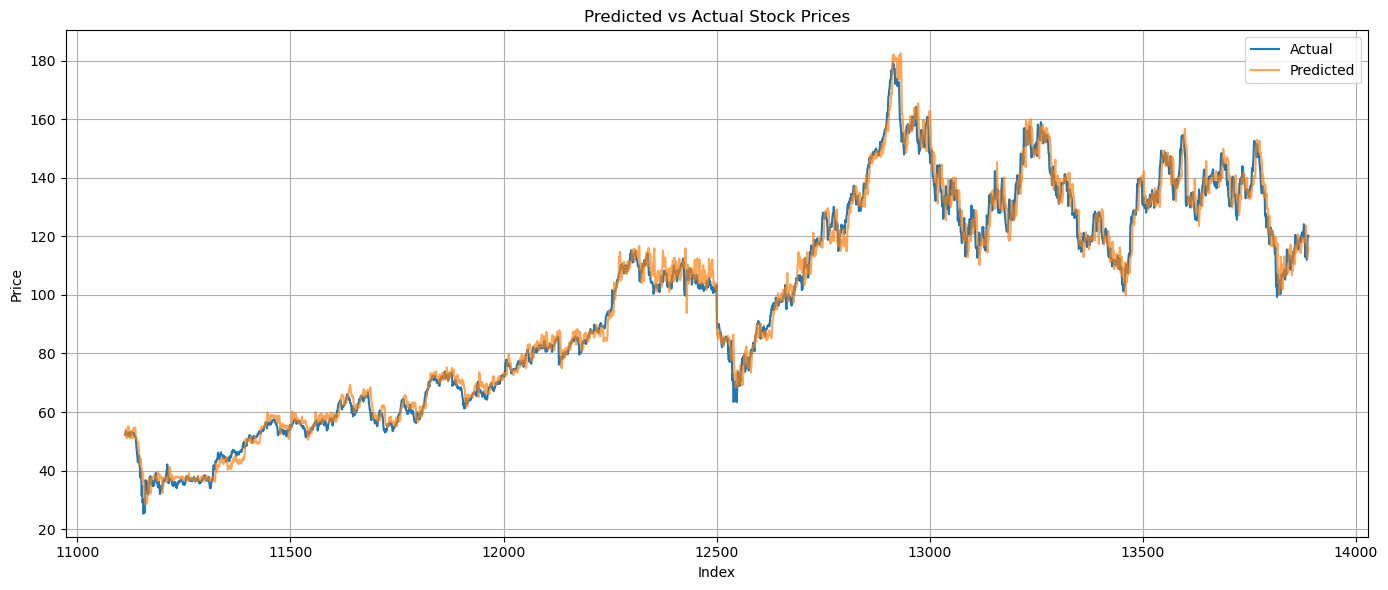


RMSE: 4.42
R² Score: 0.9854


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Debugging help
NUM_COMPANIES = 10  # Set to 500 for full run
FORCE_REDOWNLOAD = True # Set to False if the spreadsheets are downloaded and current, stops the program from redownloading the spreadsheets
SAVE_DIR = "data"
FUNDAMENTAL_DIR = "fundamentals"

# Get S&P tickers
def get_sp500_tickers():
    url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
    df = pd.read_csv(url)
    return df['Symbol'].str.replace('.', '-', regex=False).tolist()

# Download the data from yahoo
def download_stock_data(tickers, start="2020-01-01", end=None, save_dir=SAVE_DIR, force_redownload=False):
    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(FUNDAMENTAL_DIR, exist_ok=True)

    data = {}

    for i, ticker in enumerate(tickers):
        file_path = os.path.join(save_dir, f"{ticker}.csv")
        fundamentals_path = os.path.join(FUNDAMENTAL_DIR, f"{ticker}_fundamentals.csv")

        try:
            stock = yf.Ticker(ticker)

            if os.path.exists(file_path) and not force_redownload:
                print(f"Reading cached data for {ticker}")
                df = pd.read_csv(file_path)
                if 'Date' not in df.columns:
                    print(f"Skipping {ticker}: no 'Date' column.")
                    continue
                df['Date'] = pd.to_datetime(df['Date'])
                df.set_index('Date', inplace=True)
            else:
                print(f"Downloading {ticker} ({i+1}/{len(tickers)})")
                df = stock.history(start=start, end=end, auto_adjust=False)
                if df.empty or len(df) < 200:
                    print(f"Skipping {ticker}: insufficient data")
                    continue
                df.reset_index(inplace=True)
                df.to_csv(file_path, index=False)
                df.set_index('Date', inplace=True)

            # Variable data
            info = stock.info
            new_row = {
                'Date': datetime.today().strftime("%Y-%m-%d"),
                'Ticker': ticker,
                'peRatio': info.get('trailingPE', np.nan),
                'pegRatio': info.get('pegRatio', np.nan),
                'priceToSales': info.get('priceToSalesTrailing12Months', np.nan),
                'priceToBook': info.get('priceToBook', np.nan),
                'debtToEquity': info.get('debtToEquity', np.nan),
                'ebitda': info.get('ebitda', np.nan)
            }

            if os.path.exists(fundamentals_path):
                existing = pd.read_csv(fundamentals_path)
                if not ((existing['Date'] == new_row['Date']) & (existing['Ticker'] == new_row['Ticker'])).any():
                    updated = pd.concat([existing, pd.DataFrame([new_row])], ignore_index=True)
                    updated.to_csv(fundamentals_path, index=False)
            else:
                pd.DataFrame([new_row]).to_csv(fundamentals_path, index=False)

            df['Ticker'] = ticker
            data[ticker] = df
            time.sleep(0.2)

        except Exception as e:
            print(f"Error with {ticker}: {e}")

    return data

# Data processing
def preprocess_data(data):
    frames = []
    for ticker, df in data.items():
        try:
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
            df['Lag_1'] = df['Close'].shift(1)
            df['MA_5'] = df['Close'].rolling(5).mean()
            df['Return'] = df['Close'].pct_change()
            df['Target'] = df['Close'].shift(-5)
            df.dropna(inplace=True)

            if len(df) < 10:
                continue

            fund_file = os.path.join(FUNDAMENTAL_DIR, f"{ticker}_fundamentals.csv")
            if not os.path.exists(fund_file):
                continue
            row = pd.read_csv(fund_file).sort_values('Date').iloc[-1]
            for col in ['peRatio', 'pegRatio', 'priceToSales', 'priceToBook', 'debtToEquity', 'ebitda']:
                df[col] = row[col]

            df['Ticker'] = ticker
            frames.append(df)

        except Exception as e:
            print(f"Preprocessing error on {ticker}: {e}")

    if not frames:
        raise ValueError("All tickers failed during preprocessing.")

    result = pd.concat(frames)
    result.reset_index(inplace=True)
    return result

# Train the model
def train_model(df):
    y = df['Target']
    X = df.drop(columns=['Target'])

    non_numeric_cols = X.select_dtypes(include=['object', 'datetime64']).columns.tolist()
    for col in ['Date', 'Datetime']:
        if col in X.columns:
            non_numeric_cols.append(col)
    X.drop(columns=list(set(non_numeric_cols)), inplace=True)

    le = LabelEncoder()
    if 'Ticker' in df.columns:
        X['Ticker'] = le.fit_transform(df['Ticker'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    model = RandomForestRegressor(n_estimators=100, random_state=1)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    return model, X_test.index, y_test, preds, rmse, r2

# Plot the validity of the model 
def plot_predictions(index, y_true, y_pred):
    plt.figure(figsize=(14, 6))
    plt.plot(index, y_true, label='Actual')
    plt.plot(index, y_pred, label='Predicted', alpha=0.7)
    plt.title("Predicted vs Actual Stock Prices")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main
if __name__ == "__main__":
    tickers = get_sp500_tickers()[:NUM_COMPANIES]
    stock_data = download_stock_data(tickers, force_redownload=FORCE_REDOWNLOAD)
    processed = preprocess_data(stock_data)
    model, index, y_true, y_pred, rmse, r2 = train_model(processed)
    plot_predictions(index, y_true, y_pred)

    print(f"\nRMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
